In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
#from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

# Load Data

In [2]:
clean_hdb_df1 = pd.read_csv('Processed_Data/hdb_data_with_coords_mrt_dist_id.csv',
    parse_dates=['month', 'lease_commence_date'])

In [3]:
# copy
df = clean_hdb_df1.copy()

## Exploratory visualization
Flat type seems is strongly correlated with flat area

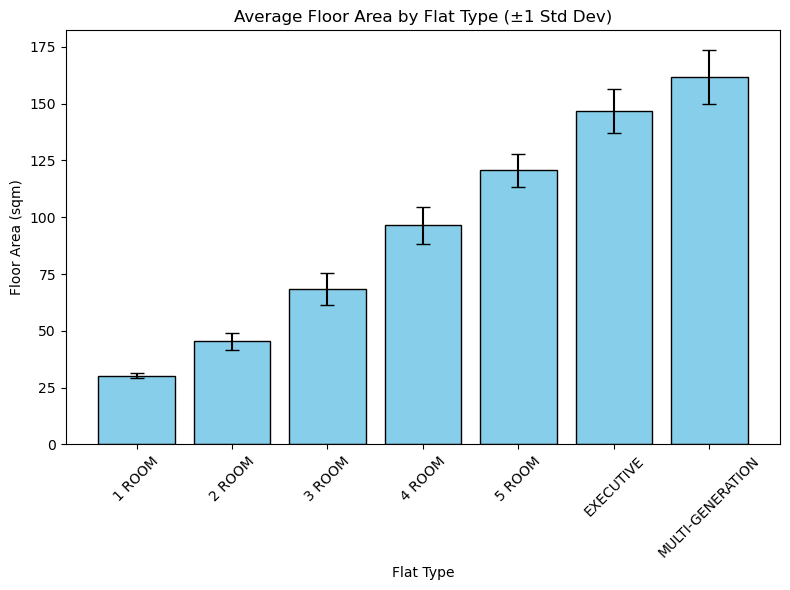

In [4]:
summary = df.groupby('flat_type')['floor_area_sqm'].agg(['mean', 'std']).sort_index()

plt.figure(figsize=(8, 6))
plt.bar(summary.index, summary['mean'], yerr=summary['std'], 
        color='skyblue', edgecolor='black', capsize=5)

plt.title('Average Floor Area by Flat Type (±1 Std Dev)')
plt.xlabel('Flat Type')
plt.ylabel('Floor Area (sqm)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Visualizing the full distribution of flat area versus flat types

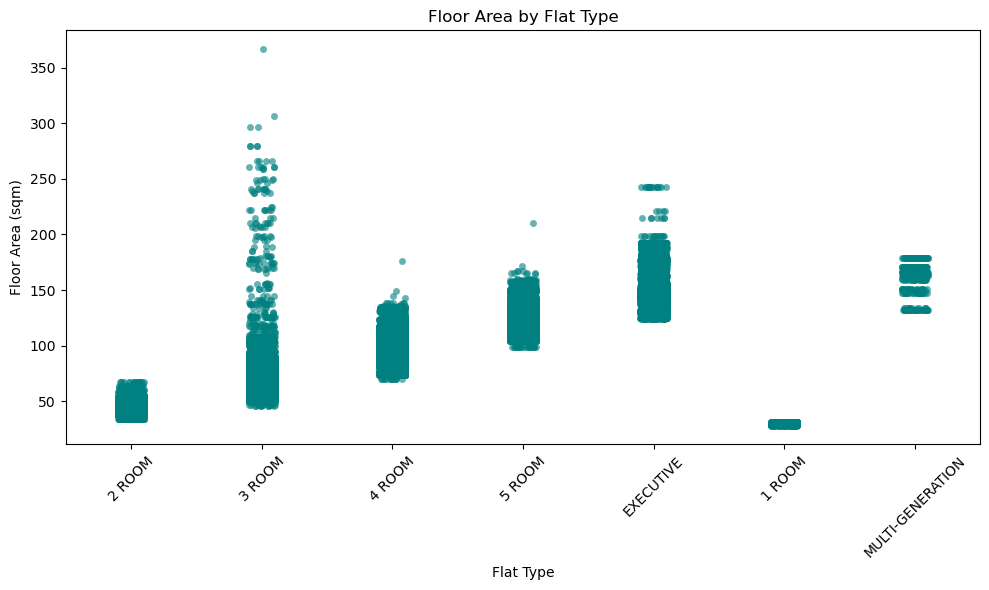

In [5]:
plt.figure(figsize=(10, 6))
sns.stripplot(x='flat_type', y='floor_area_sqm', data=df, jitter=True, alpha=0.6, color='teal')

plt.title('Floor Area by Flat Type')
plt.xlabel('Flat Type')
plt.ylabel('Floor Area (sqm)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Model 1
- Using Decision Tree Model
- Using only total floor area to predict flat-type

### Data preparation

In [6]:
X = df['floor_area_sqm']
y = df['flat_type']

In [7]:
#note that following gives data frame
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_np = X_train.to_numpy().reshape(-1, 1)
X_test_np  = X_test.to_numpy().reshape(-1, 1)
y_train_np = y_train.to_numpy()
y_test_np  = y_test.to_numpy()


### Modeling

In [8]:
model = DecisionTreeClassifier(max_depth=3, random_state=42)


In [9]:
model.fit(X_train_np, y_train_np)


,criterion,'gini'
,splitter,'best'
,max_depth,3
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


### Model Testing

In [10]:
y_pred = model.predict(X_test_np)
print(classification_report(y_test_np, y_pred))

                  precision    recall  f1-score   support

          1 ROOM       1.00      1.00      1.00       242
          2 ROOM       0.98      0.95      0.97      2665
          3 ROOM       0.98      0.98      0.98     60542
          4 ROOM       0.98      0.95      0.97     73648
          5 ROOM       0.92      0.98      0.95     40884
       EXECUTIVE       0.96      0.89      0.93     14522
MULTI-GENERATION       0.00      0.00      0.00        87

        accuracy                           0.96    192590
       macro avg       0.83      0.82      0.83    192590
    weighted avg       0.96      0.96      0.96    192590



/opt/anaconda3/envs/nus_odi/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/nus_odi/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/nus_odi/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", res

### Test report visualization
- Model1 worked very for all flat types except for "MULTI-GENERATION".
- F1 scores for all flat-types except "MULTI-GENERATION" flats are excellent >0.9.
- MULTI-GENERATION has minority data and has area that overlaps with other flat types, and therefore F1 score is extremely poor F1=0

Thus, I need an a more complex advanced model that will 
- use more features 
- apply class imbalance weights to account for minority class "MULTI-GENERATION".

### F1 score plot

/opt/anaconda3/envs/nus_odi/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/nus_odi/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/nus_odi/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", res

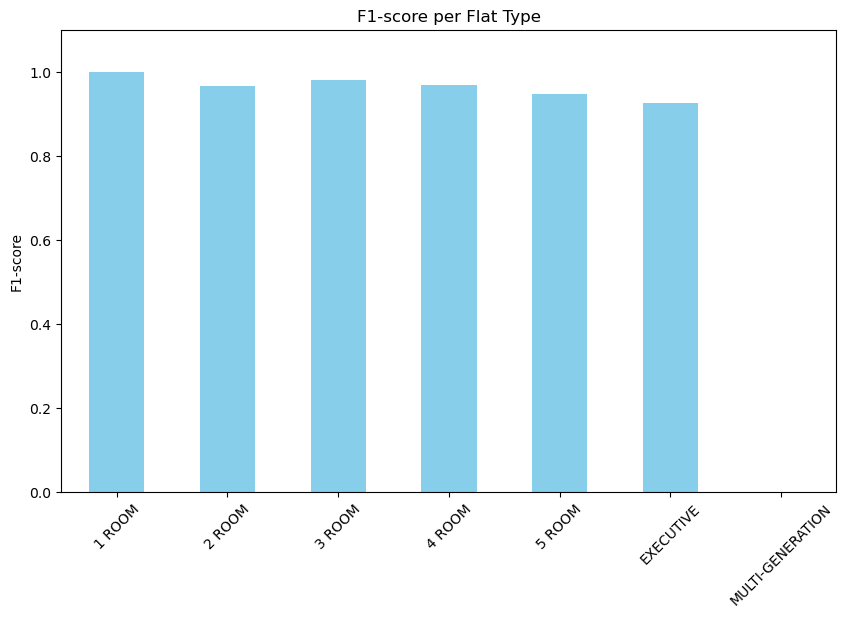

In [11]:
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Plot F1-score per class
report_df.iloc[:-3]['f1-score'].plot(kind='bar', figsize=(10,6), color='skyblue')
plt.title('F1-score per Flat Type')
plt.ylabel('F1-score')
plt.ylim(0, 1.1)
plt.xticks(rotation=45)
plt.show()

# Model 2

### Prepare Data, add more feature

In [12]:
#date type
df["month"] = pd.to_datetime(df["month"])
df["lease_commence_date"] = pd.to_datetime(df["lease_commence_date"], errors='coerce')

In [13]:
feature_df = pd.DataFrame({
    #"transaction_id": df["transaction_id"],
    #"resale_year": df["month"].dt.year,
    "town": df["town"],
    "flat_model": df["flat_model"],
    "storey_range": df["storey_range"],
    "floor_area_sqm": df["floor_area_sqm"],
    "flat_age": ((df["month"] - df["lease_commence_date"]).dt.days / 365.25).clip(lower=0),
    "resale_price" : df["resale_price"]
    #"remaining_lease": df["remaining_lease"],
    })

In [14]:
numeric_features = ['floor_area_sqm', 'flat_age',  'resale_price'] #'resale_year', 'remaining_lease',
categorical_features = ['town', 'flat_model', 'storey_range']


In [15]:

X2 = feature_df
y2 = df['flat_type']

Split into Training and Test data

In [16]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(
    X2, y2, test_size=0.2, random_state=42, stratify=y2
)

### Preprocessing pipeline

In [17]:
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=True)


In [18]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

In [19]:
#Preprocess training data
X_train2_preprocessed = preprocessor.fit_transform(X_train2)

#Transform test data using the same preprocessor
X_test2_preprocessed = preprocessor.transform(X_test2)

### Modeling

In [20]:
model2 = RandomForestClassifier(n_estimators=100, 
                                max_depth=20,
                                n_jobs=-1, 
                                random_state=42,
                                class_weight='balanced'   # this helps handle the rare classes like MULTI-GENERATION flats
                                )


In [21]:
model2.fit(X_train2_preprocessed, y_train2)

,n_estimators,100
,criterion,'gini'
,max_depth,20
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


### Testing Model2

In [22]:
y_pred2 = model2.predict(X_test2_preprocessed)
print(classification_report(y_test2, y_pred2))

                  precision    recall  f1-score   support

          1 ROOM       1.00      1.00      1.00       263
          2 ROOM       0.99      0.99      0.99      2588
          3 ROOM       0.99      1.00      1.00     60940
          4 ROOM       1.00      0.99      1.00     73567
          5 ROOM       1.00      1.00      1.00     40744
       EXECUTIVE       1.00      1.00      1.00     14378
MULTI-GENERATION       1.00      1.00      1.00       110

        accuracy                           1.00    192590
       macro avg       1.00      1.00      1.00    192590
    weighted avg       1.00      1.00      1.00    192590



### Test report visualization
- flat-type Classification report is excellent
- F1 score for all flat types is >=0.99
- F1 Score, confusion matrix showing >99% true positive is shown below
- Feature importance analysis suggests that floot area and resale prices are the best indicators of the flat-type.
- adding more weight to minority class helped improve its classification to an excellent level (100%)


### F1 score

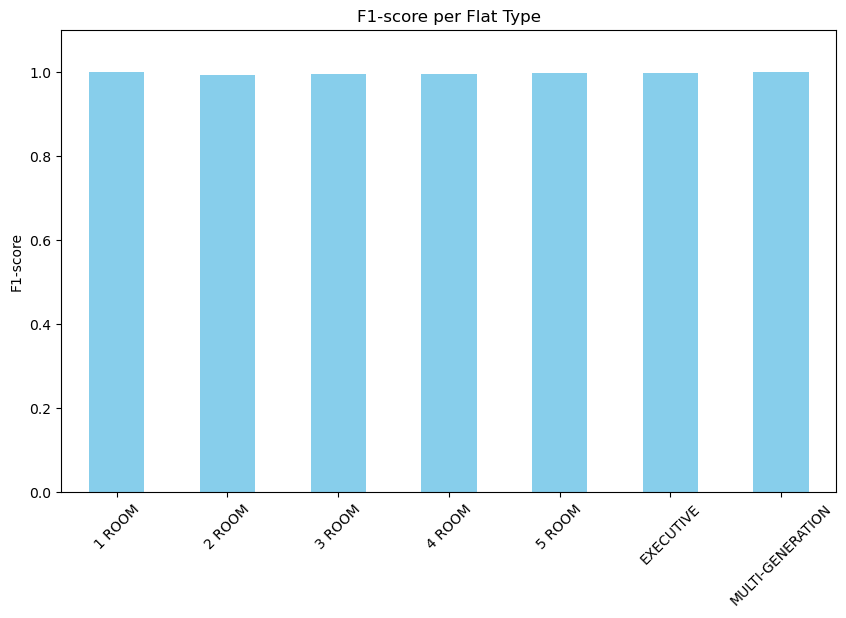

In [23]:
report2 = classification_report(y_test2, y_pred2, output_dict=True)
report_df2 = pd.DataFrame(report2).transpose()

# Plot F1-score per class
report_df2.iloc[:-3]['f1-score'].plot(kind='bar', figsize=(10,6), color='skyblue')
plt.title('F1-score per Flat Type')
plt.ylabel('F1-score')
plt.ylim(0, 1.1)
plt.xticks(rotation=45)
plt.show()


### Confusion matrix Visualization

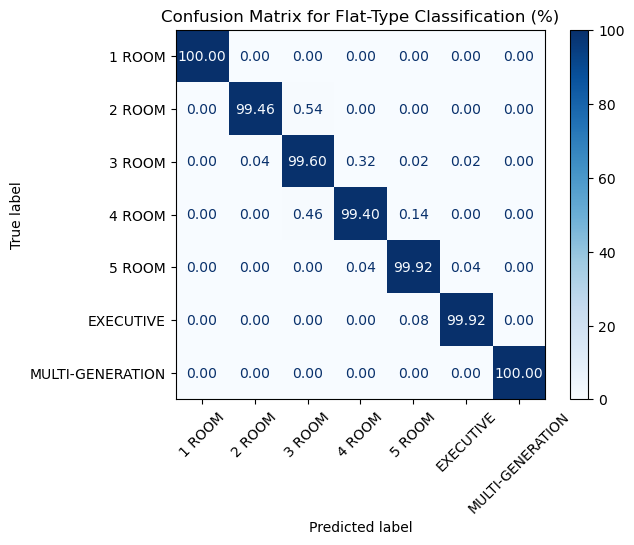

In [24]:


# Compute confusion matrix
cm = confusion_matrix(y_test2, y_pred2, labels=model2.classes_)

# Plot
#disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model2.classes_)

# Normalize to percentages
cm_percent = (cm / cm.sum(axis=1)[:, None]) * 100

#disp = ConfusionMatrixDisplay(confusion_matrix=cm / cm.sum(axis=1)[:, None],
#                              display_labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_percent,
                              display_labels=model2.classes_)
disp.plot(cmap='Blues', xticks_rotation=45, values_format='.2f')
plt.title("Confusion Matrix for Flat-Type Classification (%)")
plt.show()

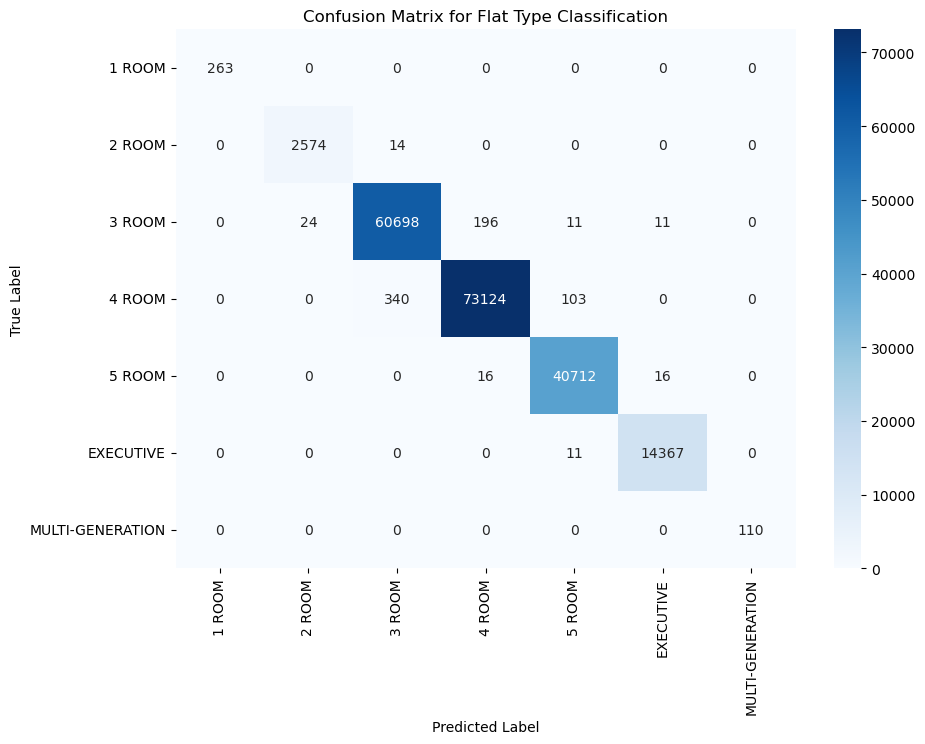

In [25]:
# Compute confusion matrix
cm = confusion_matrix(y_test2, y_pred2, labels=model2.classes_)
#cm_percent = (cm / cm.sum(axis=1)[:, None]) * 100
cm_df = pd.DataFrame(cm, index=model2.classes_, columns=model2.classes_)

plt.figure(figsize=(10, 7))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix for Flat Type Classification')
plt.show()

## Feature Importance for Model 2

In [26]:
numeric_features_list = numeric_features 
cat_features_list = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)

feature_names = np.concatenate([numeric_features_list, cat_features_list])
importances = model2.feature_importances_

In [27]:
# Check feature lengths, after preprocessing
print("Number of features:", X_train2_preprocessed.shape[1])
print("Number of feature names:", len(feature_names))

Number of features: 88
Number of feature names: 88


In [28]:
feat_imp_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)


### Feature importance plot

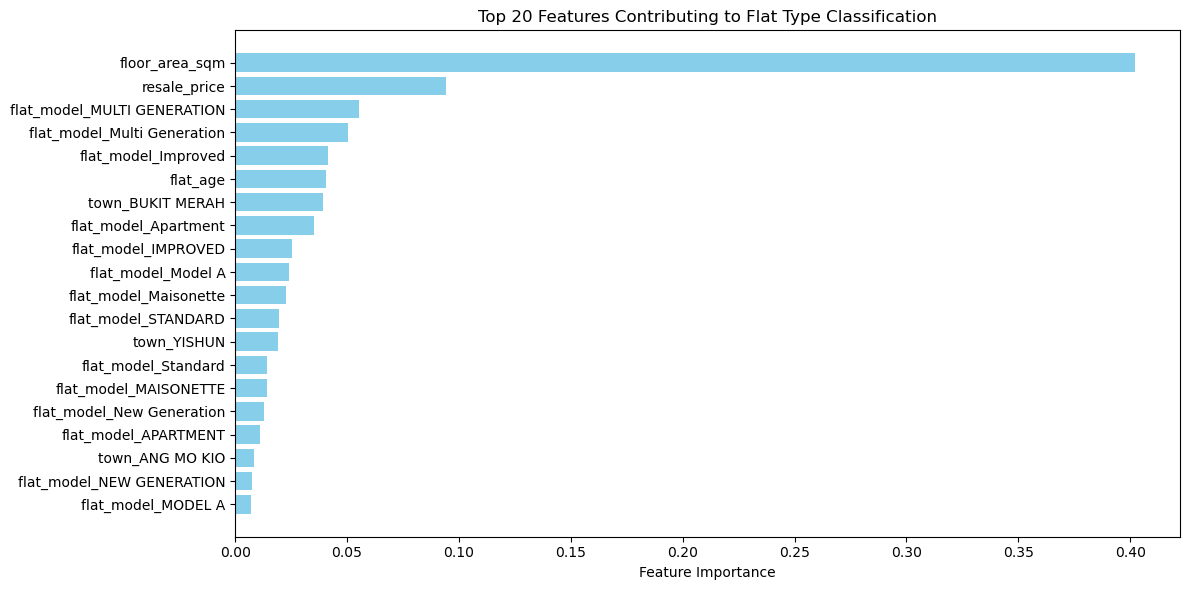

In [29]:

plt.figure(figsize=(12, 6))
plt.barh(feat_imp_df['feature'][:20][::-1], feat_imp_df['importance'][:20][::-1], color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Top 20 Features Contributing to Flat Type Classification')
plt.tight_layout()
plt.show()